In [3]:
!nvidia-smi

Tue Sep  7 01:29:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 274 kB 5.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=4a0e09ac2316cab1b25e61a4ec09c4d9923c20b5fc180fc62e639edf17813748
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.9.0+cu102 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [5]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.9")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.3 MB 769 kB/s 
     |████████████████████████████████| 49 kB 2.8 MB/s 
     |████████████████████████████████| 74 kB 2.9 MB/s 
     |████████████████████████████████| 145 kB 32.9 MB/s 
     |████████████████████████████████| 130 kB 43.1 MB/s 
     |████████████████████████████████| 745 kB 37.8 MB/s 
     |████████████████████████████████| 743 kB 39.2 MB/s 
     |████████████████████████████████| 112 kB 49.1 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20210825-py3-none-any.whl size=60661 sha256=6d39521aaf6420fd865041ddb14298e7a77ba961eeb22cfaf3e891006a9aa66c
  Stored in directory: /root/.cache/pip/wheels/53/c4/f8/c4cb07f135845218b019b4a55d8a0470a0f21ee13f8dcd16be
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=5ee9c7b2b1ec7a94a71197869c706274596196ec7d0659056435c14f84fa69

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


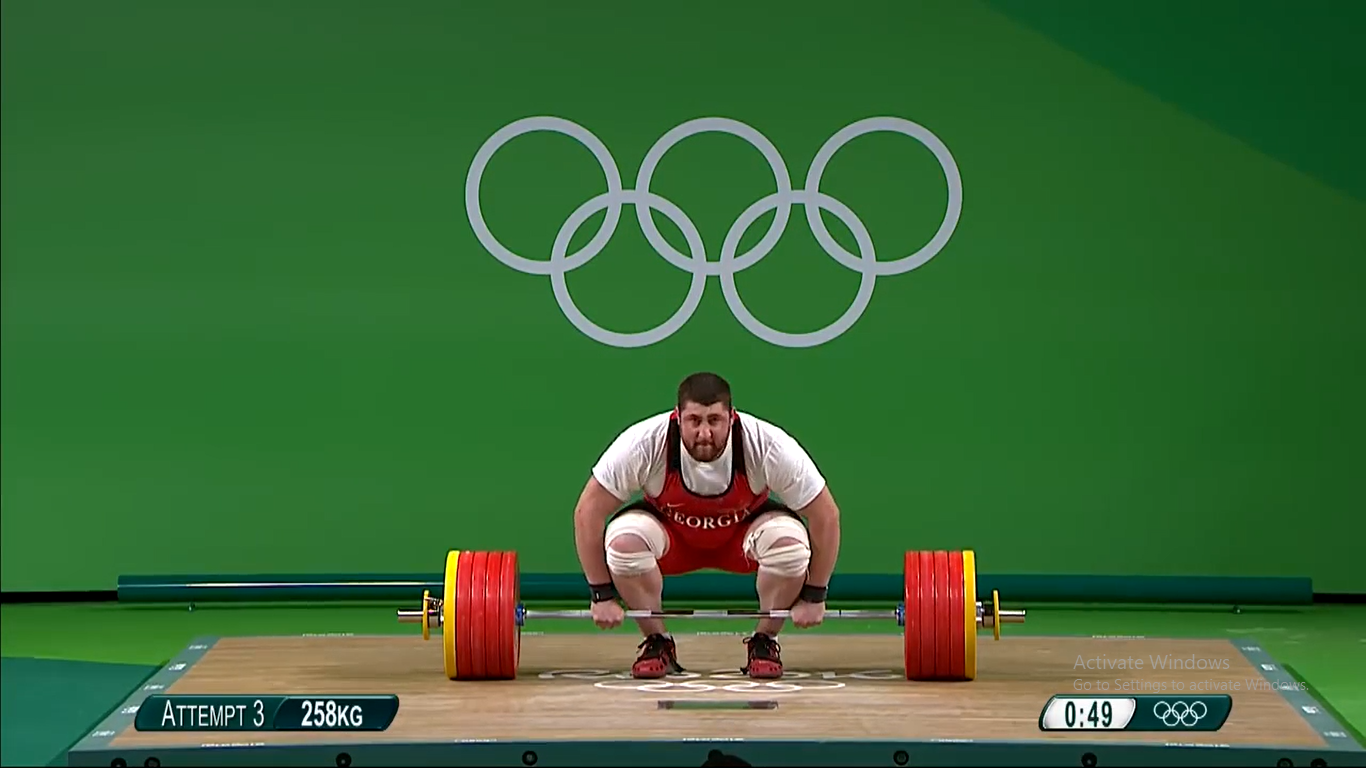

In [ ]:
im = cv2.imread("/content/drive/MyDrive/WL/Screenshot (57).png")
cv2_imshow(im)


In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:08, 20.9MB/s]                           


In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0, 13, 13], device='cuda:0')
Boxes(tensor([[ 571.1893,  375.5929,  839.3969,  677.5907],
        [ 453.1203,  552.1468,  989.6834,  672.3640],
        [ 978.9099,  591.8616, 1026.1493,  638.0076]], device='cuda:0'))


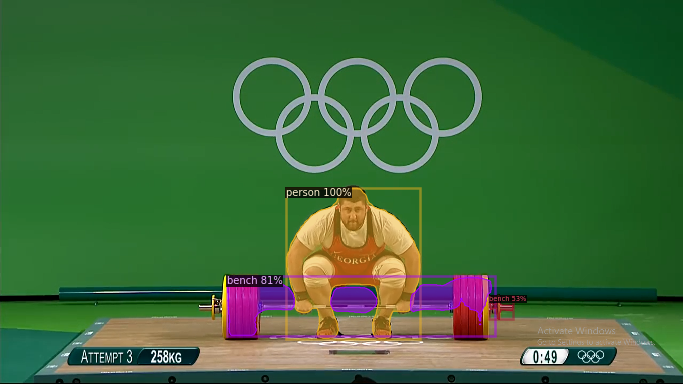

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

model_final_a6e10b.pkl: 237MB [00:10, 22.5MB/s]                           


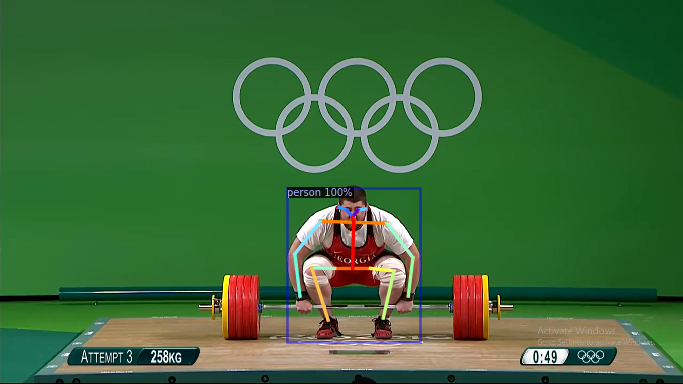

In [ ]:
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [2]:
import cv2
from google.colab.patches import cv2_imshow  
from PIL import Image  
# Create an object to read 
# from camera

video = cv2.VideoCapture('/content/drive/MyDrive/WL/weightlifting3.mp4')
# def frame_count(video):
frame_count=1
  
# We need to set resolutions.
# so, convert them from float to integer.
frame_width = int(video.get(3))
frame_height = int(video.get(4))
   
size = (frame_width, frame_height)
   
# Below VideoWriter object will create
# a frame of above defined The output 
# is stored in 'filename.avi' file.
result = cv2.VideoWriter('/content/drive/MyDrive/WL/test_weight.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                        25, size)
# print(size)
    
while(True):
    ret, frame = video.read()
  
    if ret == True: 
        outputs = predictor(frame)
        # if (frame_count>200 and frame_count<=375):
        #     cv2.putText(frame,'Lifting',(50,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,0,0),2)
        # elif (frame_count>=375 and frame_count<=455):
        #     cv2.putText(frame,'Lifted',(50,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,0,0),2)
        # # cv2.putText(frame,str(frame_count),(150,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,0,0),2)
        v = Visualizer(frame[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        # cv2_imshow(out.get_image()[:, :, ::-1])
      
        result.write(out.get_image()[:, :, ::-1])
    else:
        break
    frame_count += 1
      
# write objects
# video.release()
result.release()
# out.release()
   
print("The video was successfully saved")

The video was successfully saved
